# PLAsTiCC data exploration with TAPE

Let's explore [PLAsTiCC](http://plasticc.org) data!

It is publically avilable through [this Zenodo repository](https://zenodo.org/record/2539456).

In [1]:
## Uncomment to install packages

# !pip install tape joblib requests pyarrow.csv pyarrow

### Download the data

Please get the data from [Zenodo](https://zenodo.org/record/2539456) and put them to the `./plasticc` folder (you may change the location bellow with `DATA_DIR`).

In [2]:
from pathlib import Path

DATA_DIR = Path("./plasticc")

META_FILENAME = "plasticc_test_metadata.csv"
LC_FILENAMES = [f"plasticc_test_lightcurves_{i:02d}.csv" for i in range(1, 12)]
# META_FILENAME = "plasticc_train_metadata.csv.gz"
# LC_FILENAMES = ['plasticc_train_lightcurves.csv.gz']

N_PARTITIONS = len(LC_FILENAMES)

N_PROCESSORS = 4

You may skip the next cell if you already have the data downloaded in the `DATA_DIR`.

# Read and analyse the data with TAPE

In [3]:
%%time

import light_curve as licu
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# In TAPE's (and LSST's) terminology, sources are individual detections,
# and objects are the underlying astrophysical objects.

# We load object table first, from the metadata file.
print("Loading object table...")
object_table = dd.read_csv(
    DATA_DIR / META_FILENAME,
    # Read data chunk by chunk, to avoid loading the whole file into memory.
    blocksize=100e6,
)

# Then we load the sources:
print("Loading source tables...")
source_table = dd.read_csv(
    [DATA_DIR / filename for filename in LC_FILENAMES],
    blocksize=100e6,
)

# Now we can make an Ensemble.
# To make parallel processing work we need to partition the data.
# After that, when we run analysis, TAPE will distribute the work:
# one partition per worker.
print("Building Ensemble...")
ens = Ensemble(
    n_workers=N_PROCESSORS,
)
ens.from_dask_dataframe(
    source_frame=source_table,
    object_frame=object_table,
    npartitions=None,
    column_mapper=ColumnMapper(
        id_col='object_id',
        time_col='mjd',
        flux_col='flux',
        err_col='flux_err',
        band_col='passband',
    ),
    # TODO: Doug, please put a comment here about the following line.
    sync_tables=False,
)

# Let's run some analysis!

print("Starting analysis...")
# First, let's select only Galactic objects, by cutting on hostgal_photoz.
print("First, filter by photoz")
ens = ens.query("hostgal_photoz < 1e-3", table="object")

# Second, let's select persistent sources, by cutting on the duration of the light curve.
print("Extract durations")
duration = ens.batch(
    lambda time, detected: np.ptp(time[np.asarray(detected, dtype=bool)]),
    ens._time_col, 'detected_bool',
    meta=('duration', 'float64'),
    use_map=False,
    compute=False,
)
print("Assign a column")
ens.assign(table="object", duration=duration)
print("Filter by duration")
ens = ens.query("duration > 366", table="object")

# Next, we use Otsu's method to split light curves into two groups:
# one with high flux, and one with low flux. Eclipsing binaries should have
# lower flux group smaller than the higher flux group, but having larger 
# variability. We use light-curve package to extract these features.
# (https://github.com/light-curve/light-curve-python)
# For simplicity, we only calculate these features for the i (3) band.
print("Extract Otsu features")
otsu_features = ens.batch(licu.OtsuSplit(), band_to_calc=3, use_map=False, compute=False)
print("Assign columns")
ens = ens.assign(
    table="object",
    otsu_lower_to_all_ratio=otsu_features['otsu_lower_to_all_ratio'],
    otsu_std_lower=otsu_features['otsu_std_lower'],
    otsu_std_upper=otsu_features['otsu_std_upper'],
)
print('Filter by Otsu features')
ens = ens.query(
    "otsu_lower_to_all_ratio < 0.1 and otsu_std_lower > otsu_std_upper",
    table="object",
)
print("Compute object table")
ens = ens.compute("object")

Loading object table...
Loading source tables...
Building Ensemble...
Starting analysis...
First, filter by photoz
Extract durations
Assign a column
Filter by duration
Extract Otsu features
Assign columns
Filter by Otsu features
Compute object table
CPU times: user 8.47 s, sys: 4.79 s, total: 13.3 s
Wall time: 1min 33s


In [4]:
ens

,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,...,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y,duration,otsu_lower_to_all_ratio,otsu_std_lower,otsu_std_upper
object_id,,,,,,,,,,,,,,,,,,,,,
1040934,192.1674,-46.3751,0,-9.0,0.0,0.0,-9.0,0.083,0,65,...,5.7,33.7,110.5,539.1,1183.9,1991.1,410.0927,0.090909,10.038970,7.000799
1145188,104.4141,-12.1773,0,-9.0,0.0,0.0,-9.0,0.625,0,16,...,341.5,3106.7,3207.9,2379.2,1631.3,717.8,1073.9476,0.090909,111.621817,67.960107
1184639,326.9531,-22.8314,0,-9.0,0.0,0.0,-9.0,0.032,0,16,...,2114.8,19954.1,20819.5,15006.2,9573.4,3997.2,728.8966,0.086957,563.869493,25.370866
1226593,48.5156,-32.2662,0,-9.0,0.0,0.0,-9.0,0.014,0,65,...,15.0,25.1,43.4,140.4,285.6,467.0,830.8233,0.080000,12.008922,4.690816
1227515,183.3398,-16.9578,0,-9.0,0.0,0.0,-9.0,0.049,0,16,...,733.2,11232.6,16446.4,14553.2,10543.4,4789.5,1056.0646,0.095238,765.642029,122.818703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130633244,152.9297,-12.4828,0,-9.0,0.0,0.0,-9.0,0.058,0,16,...,232.1,1957.9,1864.3,1267.8,781.9,319.2,1086.8704,0.080000,57.311277,12.255049
130634660,36.8182,-46.7685,0,-9.0,0.0,0.0,-9.0,0.014,0,16,...,51.2,379.4,331.9,214.8,128.2,51.3,839.7401,0.080000,8.145193,7.080347
130708654,95.0977,-36.0536,0,-9.0,0.0,0.0,-9.0,0.052,0,16,...,2059.7,20970.8,23290.0,17505.6,11486.4,4893.3,1008.0936,0.095238,1425.256064,480.315334


### Do the same, but with Pandas + joblib

The workflow is challenger here: we don't like to load all the light curves into memory (~20 GBi), so we have to manually jump between object table processing and source table processing.

NB: We also need `pyarrow.csv`, but only to read CSVs faster into pandas data-frames.

### Do the same but with Pandas + joblib

In [5]:
%%time

import light_curve as licu
import numpy as np
import pandas as pd
import pyarrow as pa
from joblib import Parallel, delayed


def read_object_table(filename):
    # Set number of threads to use when reading CSVs
    pa.set_cpu_count(N_PROCESSORS)
    pa.set_io_thread_count(N_PROCESSORS)
    return pd.read_csv(filename, engine='pyarrow', index_col='object_id')

# First we load object table, from the metadata file.
print("Loading object table...")
object_table = read_object_table(DATA_DIR / META_FILENAME)

print("Pre-filter object table")
# Before doing light-curve analysis we select only Galactic objects, by cutting on hostgal_photoz.
object_table = object_table[object_table['hostgal_photoz'] < 1e-3]


def read_source_table(filename):
    # We are going to read in parallel, so we set single thread 
    pa.set_cpu_count(1)
    pa.set_io_thread_count(1)
    return pd.read_csv(filename, engine='pyarrow', index_col='object_id')


def process_source_table(filename):
    source_table = read_source_table(filename)
    
    # Select sources for objects left
    source_table = source_table[source_table.index.isin(object_table.index)]
    
    # Select persistent sources, by cutting on the duration of the light curve.
    detections = source_table[source_table['detected_bool'].astype(bool)]
    # We need to group detections by object_id, to get light curves:
    durations = detections['mjd'].groupby(level=0).apply(np.ptp)
    
    # Then we filter the source table to keep only persistent sources:
    source_table = source_table.loc[durations[durations > 366].index]
    
    
    # Next, we use Otsu's method to split light curves into two groups:
    # one with high flux, and one with low flux. Eclipsing binaries should have
    # lower flux group significantly smaller than the higher flux group,
    # but having larger variability.
    # We use light-curve package to extract these features.
    # (https://github.com/light-curve/light-curve-python)
    # For simplicity, we only calculate these features for the i (3) band.
    
    otsu_split = licu.OtsuSplit()
    i_band_sources = source_table[source_table['passband'] == 3]
    otsu_features = i_band_sources[['mjd', 'flux', 'flux_err']].groupby(level=0).apply(lambda row: pd.Series(
        otsu_split(
            np.asarray(row['mjd']),
            np.asarray(row['flux']),
            np.asarray(row['flux_err']),
            sorted=True,
            check=False,
        ),
        index=otsu_split.names,
    ))
    
    # And filter by Otsu features
    otsu_idx = (otsu_features['otsu_lower_to_all_ratio'] < 0.1) & (otsu_features['otsu_std_lower'] > otsu_features['otsu_std_upper'])
    
    return source_table.loc[otsu_idx.index[otsu_idx]]


# Running the main part of the analysis in parallel
print("Run analysis in parallel...")
source_tables = Parallel(n_jobs=N_PROCESSORS)(
    delayed(process_source_table)(DATA_DIR / filename) for filename in LC_FILENAMES
)
source_table = pd.concat(source_tables, ignore_index=False, sort=True)
object_table = object_table.loc[np.unique(source_table.index)]
object_table

Loading object table...
Pre-filter object table
Run analysis in parallel...


/Users/hombit/.virtualenvs/tape/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 2.44 s, sys: 624 ms, total: 3.06 s
Wall time: 1min 2s


,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
object_id,,,,,,,,,,,,,,,,,,,,,
1040934,192.1674,-46.3751,0,-9.0,0.0,0.0,-9.0,0.083,0,65,...,0.0,0.0,59570.0,9868,5.7,33.7,110.5,539.1,1183.9,1991.1
1145188,104.4141,-12.1773,0,-9.0,0.0,0.0,-9.0,0.625,0,16,...,0.0,0.0,59570.0,48177,341.5,3106.7,3207.9,2379.2,1631.3,717.8
1184639,326.9531,-22.8314,0,-9.0,0.0,0.0,-9.0,0.032,0,16,...,0.0,0.0,59570.0,23011,2114.8,19954.1,20819.5,15006.2,9573.4,3997.2
1226593,48.5156,-32.2662,0,-9.0,0.0,0.0,-9.0,0.014,0,65,...,0.0,0.0,59570.0,27347,15.0,25.1,43.4,140.4,285.6,467.0
1227515,183.3398,-16.9578,0,-9.0,0.0,0.0,-9.0,0.049,0,16,...,0.0,0.0,59570.0,29428,733.2,11232.6,16446.4,14553.2,10543.4,4789.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130633244,152.9297,-12.4828,0,-9.0,0.0,0.0,-9.0,0.058,0,16,...,0.0,0.0,59570.0,38515,232.1,1957.9,1864.3,1267.8,781.9,319.2
130634660,36.8182,-46.7685,0,-9.0,0.0,0.0,-9.0,0.014,0,16,...,0.0,0.0,59570.0,39616,51.2,379.4,331.9,214.8,128.2,51.3
130708654,95.0977,-36.0536,0,-9.0,0.0,0.0,-9.0,0.052,0,16,...,0.0,0.0,59570.0,17929,2059.7,20970.8,23290.0,17505.6,11486.4,4893.3


### Do the same, but with Pandas+PyArrow w/ nested arrays for dataframes, and joblib for parallelism

In [6]:
%%time

import light_curve as licu
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.csv as pacsv
from joblib import Parallel, delayed

# Read the data
# -------------

def read_object_table(filename):
    pa.set_cpu_count(N_PROCESSORS)
    pa.set_io_thread_count(N_PROCESSORS)
    object_table = pacsv.read_csv(
        filename,
        # We'd like to load the whole file into a single partition
        read_options=pacsv.ReadOptions(block_size=np.iinfo(np.int32).max),
    )
    df = pd.DataFrame(
        {
            col: pd.Series(
                object_table[col],
                dtype=pd.ArrowDtype(object_table[col].type),
                index=object_table['object_id'],
                copy=False,
            )
            for col in object_table.column_names if col != 'object_id'
        },
    )
    diff_index = np.diff(df.index.values)
    assert np.all(diff_index > 0), "Object table index must be strictly sorted."
    return df

# First we load object table, from the metadata file.
print("Loading object table...")
object_table = read_object_table(DATA_DIR / META_FILENAME)
object_table = object_table[object_table['hostgal_photoz'] < 1e-3]


def read_source_table(filename):
    table = pacsv.read_csv(
        filename,
        # We'd like to have a partition per an original file
        read_options=pacsv.ReadOptions(block_size=np.iinfo(np.int32).max),
    )
    df = pd.DataFrame(
        {
            col: pd.Series(
                table[col],
                dtype=pd.ArrowDtype(table[col].type),
                index=table['object_id'],
                copy=False,
            )
            for col in table.column_names if col != 'object_id'
        },
    )
    return df

def nested_array_view(df):
    # Strict sorting is actually not required,
    # what is required is that index is batched by object_id, so single source objects are not split.
    # Here for simplicity we assume that the index is strictly sorted.
    
    index_diff = np.diff(df.index.values, prepend=df.index.values[0]-1, append=df.index.values[-1]+1)
    if np.any(index_diff < 0):
        raise ValueError("Table index must be strictly sorted.")
    offset = np.nonzero(index_diff)[0]
    object_index = df.index.values[offset[:-1]]
    
    series_ = {}
    for column in df.columns:
        list_array = pa.ListArray.from_arrays(
            offset,
            pa.array(df[column]),
        )
        series_[column] = pd.Series(
            list_array,
            dtype=pd.ArrowDtype(list_array.type),
            index=object_index,
            copy=False,
        )
    return pd.DataFrame(series_)


def flat_view(df):
    series_ = {}
    index = None
    
    for column in df.columns:
        if not is_list_dtype(df[column]):
            continue
        list_array = pa.array(df[column])
        if index is None:
            index = np.repeat(df.index.values, np.diff(list_array.offsets))
        series_[column] = pd.Series(
            list_array.flatten(),
            dtype=pd.ArrowDtype(list_array.type.value_type),
            index=index,
            copy=False,
        )
    
    if index is None:
        raise ValueError("No nested arrays in the dataframe.")
    
    return pd.DataFrame(series_)
    

def is_list_dtype(series):
    dtype = series.dtype
    try:
        pyarrow_dtype = dtype.pyarrow_dtype
    except AttributeError:
        return False
    return pa.types.is_list(pyarrow_dtype)


def apply_validity_mask_df(df, validity_mask):
    validity_bitmask = np.packbits(validity_mask, bitorder='little')
    validity_mask_buffer = pa.py_buffer(validity_bitmask)
    
    series_ = {}
    for column in df.columns:
        if not is_list_dtype(df[column]):
            series_[column] = df[column]
            continue
        list_array = pa.array(df[column])
        value_array = pa.Array.from_buffers(
            list_array.values.type,
            len(list_array.values),
            [validity_mask_buffer, list_array.buffers()[3]]
        )
        masked_list_array = pa.Array.from_buffers(
            list_array.type,
            len(list_array),
            list_array.buffers()[:2],
            children=[value_array],
        )
        series_[column] = pd.Series(
            masked_list_array,
            dtype=pd.ArrowDtype(masked_list_array.type),
            index=df.index,
            copy=False,
        )
    return pd.DataFrame(series_)

def process_source_table(filename):
    # Disable parallelism in pyarrow, because we are going to use joblib
    pa.set_cpu_count(1)
    pa.set_io_thread_count(1)
    
    # Read the source table
    source_table = read_source_table(filename)
    # Convert it to nested arrays
    source_table_view = nested_array_view(source_table)
    # Join with object table by index
    df = source_table_view.join(object_table, how='inner')
    
    # Next, we have two ways to filter sources:
    # 1. Create a mask in the original data
    # 2. Create a new copy of the date like we do in pandas
    # Attempt to do the first approach:
    # detections = apply_validity_mask_df(df, source_table['detected_bool']) 
    # The first one is actually not supported by pandas currently, so we do the second one.
    detections = flat_view(df)
    detections = detections[detections['detected_bool'].astype(bool)]
    detections = nested_array_view(detections)
    
    durations = detections['mjd'].apply(np.ptp)
    
    # Then we filter the source table to keep only persistent sources:
    df = df.loc[durations > 366]
    
    # Now we do the second way to filter sources and select i-band (3) sources:
    source_table = flat_view(df)
    i_band_sources = source_table[source_table['passband'] == 3]
    i_band_sources_view = nested_array_view(i_band_sources)
    
    # So now we can apply Otsu features to this view
    otsu_split = licu.OtsuSplit()
    # For some reason I cannot apply for the table with few columns only,
    # so I apply for the whole table
    otsu_features = i_band_sources_view.apply(
        lambda row: pd.Series(
            otsu_split(
                row['mjd'],
                row['flux'],
                row['flux_err'],
                sorted=True,
                check=False,
            ),
            index=otsu_split.names,
        ),
        axis=1
    )
    
    # And filter by Otsu features
    otsu_idx = (otsu_features['otsu_lower_to_all_ratio'] < 0.1) & (otsu_features['otsu_std_lower'] > otsu_features['otsu_std_upper'])
    df = df.loc[otsu_idx.index[otsu_idx]]
    
    return df

# Running the main part of the analysis in parallel
print("Run analysis in parallel...")
dfs = Parallel(n_jobs=N_PROCESSORS)(
    delayed(process_source_table)(DATA_DIR / filename) for filename in LC_FILENAMES
)
# dfs = [process_source_table(DATA_DIR / filename) for filename in LC_FILENAMES[1:2]]
df = pd.concat(dfs, ignore_index=False, sort=True)
df

Loading object table...
Run analysis in parallel...


/Users/hombit/.virtualenvs/tape/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 2.35 s, sys: 954 ms, total: 3.3 s
Wall time: 39.1 s


,ddf_bool,decl,detected_bool,distmod,flux,flux_err,hostgal_photoz,hostgal_photoz_err,hostgal_specz,libid_cadence,...,tflux_z,true_av,true_distmod,true_lensdmu,true_peakmjd,true_rv,true_submodel,true_target,true_vpec,true_z
1040934,0,-46.3751,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0...,-9.0,[-7.13183500e+00 -1.67555400e+00 -1.46274040e+...,[24.910471 8.225894 29.578571 30.817764 18.80...,0.0,0.0,-9.0,9868,...,1183.9,0.0,0.0,0.0,59570.0,0.0,1,65,0.0,0.0
1145188,0,-12.1773,[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0...,-9.0,[ 2.01896759e+02 -5.43462720e+01 9.20216140e+...,[132.012451 89.273819 13.01166 21.845282 ...,0.0,0.0,-9.0,48177,...,1631.3,0.0,0.0,0.0,59570.0,0.0,1,16,0.0,0.0
1184639,0,-22.8314,[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0...,-9.0,[-2.22401620e+01 -5.80760500e+00 -5.58351074e+...,[16.597025 11.437782 27.755817 29.08077 12.45...,0.0,0.0,-9.0,23011,...,9573.4,0.0,0.0,0.0,59570.0,0.0,1,16,0.0,0.0
1226593,0,-32.2662,[1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0...,-9.0,[ -18.450275 -18.901358 -15.503196 -17.5606...,[ 2.760279 1.630008 8.030293 5.243636 16.38...,0.0,0.0,-9.0,27347,...,285.6,0.0,0.0,0.0,59570.0,0.0,1,65,0.0,0.0
1227515,0,-16.9578,[1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1...,-9.0,[ 256.808472 580.386169 -2067.059082 384....,[ 9.375149 12.195236 17.249441 24.435997 24.77...,0.0,0.0,-9.0,29428,...,10543.4,0.0,0.0,0.0,59570.0,0.0,1,16,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130633244,0,-12.4828,[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0...,-9.0,[ 15.281292 23.143011 30.033777 46.8806...,[12.860787 9.366933 9.572536 30.774542 46.54...,0.0,0.0,-9.0,38515,...,781.9,0.0,0.0,0.0,59570.0,0.0,1,16,0.0,0.0
130634660,0,-46.7685,[0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1...,-9.0,[ 5.489279 13.043737 -10.158617 6.849087 ...,[11.924296 8.830238 13.986683 22.594 7.65...,0.0,0.0,-9.0,39616,...,128.2,0.0,0.0,0.0,59570.0,0.0,1,16,0.0,0.0
130708654,0,-36.0536,[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0...,-9.0,[ 2.51816560e+01 1.28216450e+01 -1.20907370e+...,[42.871826 28.221752 31.46002 26.589155 18.64...,0.0,0.0,-9.0,17929,...,11486.4,0.0,0.0,0.0,59570.0,0.0,1,16,0.0,0.0
130711141,0,-47.1613,[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1...,-9.0,[-9.37930847e+02 2.62816498e+02 1.42802277e+...,[1199.095215 118.098534 49.441616 48.4889...,0.0,0.0,-9.0,32180,...,4922.0,0.0,0.0,0.0,59570.0,0.0,1,16,0.0,0.0


NameError: name 'extract_band' is not defined

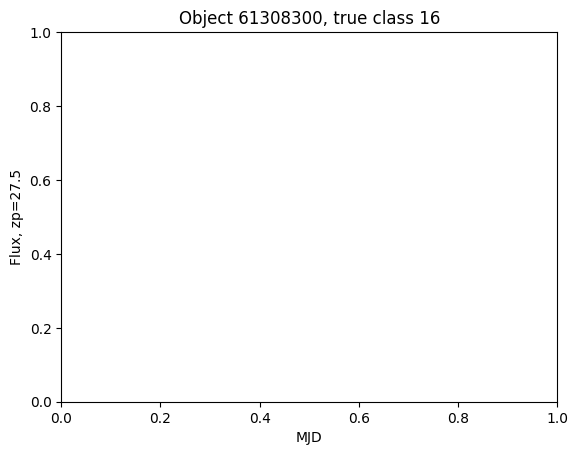

In [7]:
import matplotlib.pyplot as plt

LSST_BANDS = 'ugrizy'

def plot(row):
    plt.figure()
    plt.title(f"Object {row.Index}, true class {row.true_target}")
    plt.xlabel('MJD')
    plt.ylabel('Flux, zp=27.5')
    for band_idx, band_name in enumerate(LSST_BANDS):
        mjd, flux, flux_err = extract_band(
            row.mjd,
            row.flux,
            row.flux_err,
            bands=row.passband,
            band_to_calc=band_idx,
        )
        color = f'C{band_idx}'
        plt.scatter(mjd, flux, c=color, label=band_name)
        plt.errorbar(mjd, flux, yerr=flux_err, ls='none', c=color)
        plt.legend()

# Random objects from the selected sample
for row in object_table[object_table['true_target'] == 16].sample(5, random_state=0).itertuples():
    plot(row)
    
# Random objects from the selected sample
for row in df.sample(5, random_state=0).itertuples():
    plot(row)